In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class

    def forward(self, x):
        x[x == 255] = 21
        return F.one_hot(x.to(torch.int64), self.num_class).permute(0, 3, 1, 2)[0].float()

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.PILToTensor(), 
        MakeClass(22)
    ]
)

train_ds = VOCSegmentation(
    root = "~/data", image_set = "train", download = True, year = "2011",
    transform = transform, 
    target_transform = target_transform
)

valid_ds = VOCSegmentation(
    root = "~/data", image_set = "trainval", download = True, year = "2011",
    transform = transform, 
    target_transform = target_transform    
)

test_ds = VOCSegmentation(
    root = "~/data", image_set = "val", download = True, year = "2011",
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

Using downloaded and verified file: /home/khoidh/data/VOCtrainval_25-May-2011.tar
Extracting /home/khoidh/data/VOCtrainval_25-May-2011.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_25-May-2011.tar
Extracting /home/khoidh/data/VOCtrainval_25-May-2011.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_25-May-2011.tar
Extracting /home/khoidh/data/VOCtrainval_25-May-2011.tar to /home/khoidh/data
#Training Samples: 1112
#Validation Samples: 2223
#Testing Samples: 1111
#Training Batch: 35
#Validation Batch: 70
#Testing Batch: 35


Total #Class: 22
data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([22, 256, 256])
Number classes: 22
Classes: tensor([ 0, 15, 21])


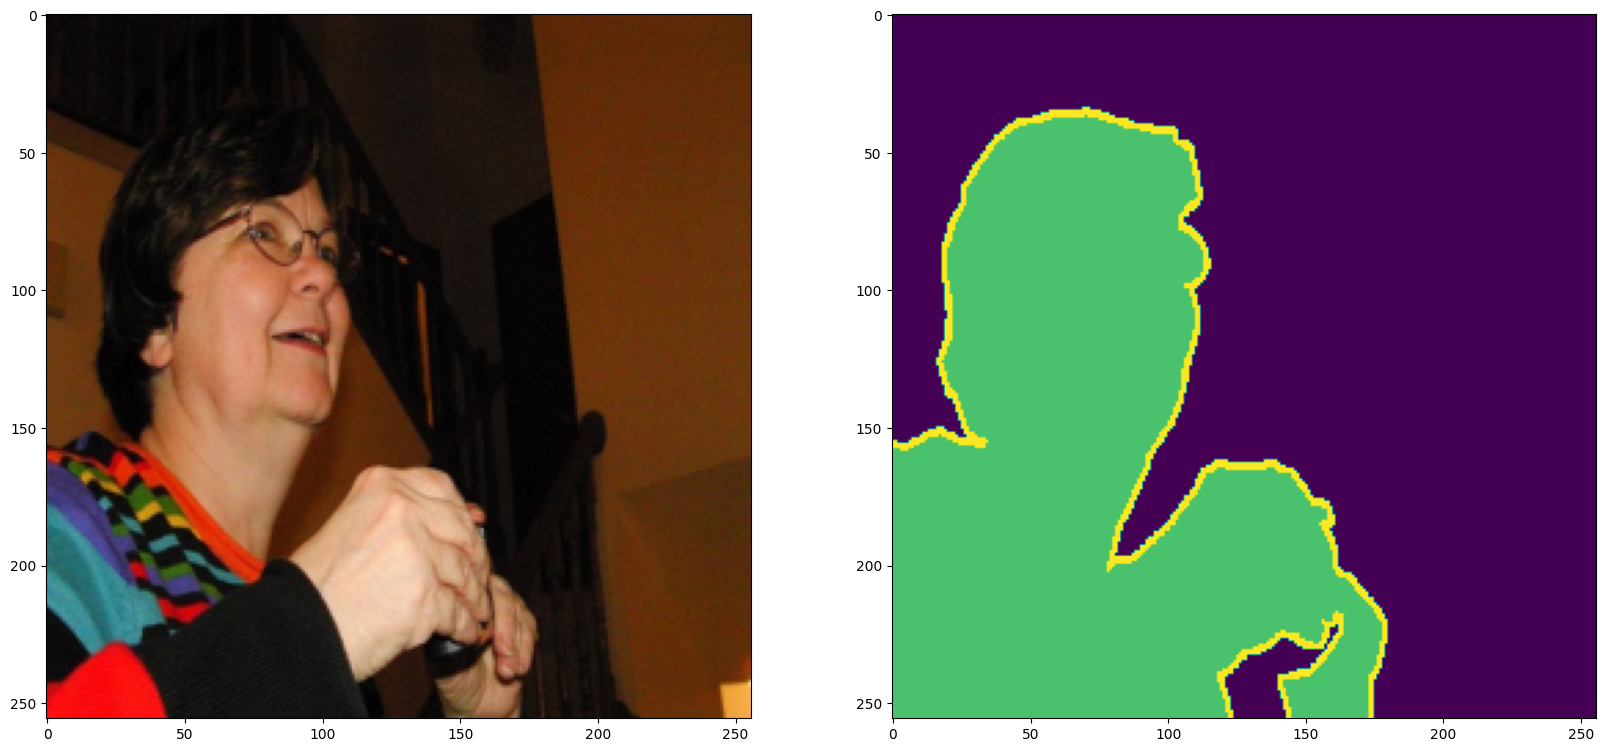

In [3]:
sample_data, sample_mask = train_ds[200]
total_num_class = 22

print(f"Total #Class: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, total_num_class, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [11]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_rec_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = valid_rec_loss + valid_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(valid_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.25it/s]


Epoch: 0 - TrainLoss: 3.400022990362985 - ValidLoss: 2.456799840927124


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.17it/s]


Epoch: 1 - TrainLoss: 2.612747212818691 - ValidLoss: 2.550014328956604


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.13it/s]


Epoch: 2 - TrainLoss: 2.1096442461013796 - ValidLoss: 2.1139913780348643


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


Epoch: 3 - TrainLoss: 1.8231875147138323 - ValidLoss: 1.7489451697894505


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


Epoch: 4 - TrainLoss: 1.702737648146493 - ValidLoss: 1.7471399784088135


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


Epoch: 5 - TrainLoss: 1.6552434955324447 - ValidLoss: 1.6845593741961888


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


Epoch: 6 - TrainLoss: 1.6192094496318272 - ValidLoss: 1.6492463963372366


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.15it/s]


Epoch: 7 - TrainLoss: 1.5993999821799143 - ValidLoss: 1.7313434515680586


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


Epoch: 8 - TrainLoss: 1.585331804411752 - ValidLoss: 1.6139153344290598


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


Epoch: 9 - TrainLoss: 1.5597024713243757 - ValidLoss: 1.6900938034057618


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.14it/s]


Epoch: 10 - TrainLoss: 1.5365485600062778 - ValidLoss: 1.5788581660815648


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


Epoch: 11 - TrainLoss: 1.526088946206229 - ValidLoss: 1.5494747536523001


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


Epoch: 12 - TrainLoss: 1.4899933235985892 - ValidLoss: 1.6268933483532497


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


Epoch: 13 - TrainLoss: 1.4831547260284423 - ValidLoss: 1.5338549954550607


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.20it/s]


Epoch: 14 - TrainLoss: 1.481075586591448 - ValidLoss: 1.5099393725395203


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


Epoch: 15 - TrainLoss: 1.446384174483163 - ValidLoss: 1.4812020574297224


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


Epoch: 16 - TrainLoss: 1.4136212723595756 - ValidLoss: 1.4755126314503806


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  6.13it/s]


Epoch: 17 - TrainLoss: 1.4172340801783971 - ValidLoss: 1.5013303399085998


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  6.07it/s]


Epoch: 18 - TrainLoss: 1.4083353655678885 - ValidLoss: 1.5667791025979179


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:13<00:00,  5.38it/s]


Epoch: 19 - TrainLoss: 1.3915669509342738 - ValidLoss: 1.5052931581224713


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  6.05it/s]


Epoch: 20 - TrainLoss: 1.3814819369997298 - ValidLoss: 1.4559130924088615


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  5.84it/s]


Epoch: 21 - TrainLoss: 1.3607858521597727 - ValidLoss: 1.4040248921939305


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


Epoch: 22 - TrainLoss: 1.3278570345469884 - ValidLoss: 1.4349149244172232


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.56it/s]


Epoch: 23 - TrainLoss: 1.3205304758889334 - ValidLoss: 1.5424535308565412


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


Epoch: 24 - TrainLoss: 1.2933858122144426 - ValidLoss: 1.4151626569884164


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  5.84it/s]


Epoch: 25 - TrainLoss: 1.2995029807090759 - ValidLoss: 1.4503513251032147


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


Epoch: 26 - TrainLoss: 1.282665068762643 - ValidLoss: 1.3928195459502084


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


Epoch: 27 - TrainLoss: 1.2628144945417132 - ValidLoss: 1.4505336284637451


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.41it/s]


Epoch: 28 - TrainLoss: 1.2602303743362426 - ValidLoss: 1.3808341383934022


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.58it/s]


Epoch: 29 - TrainLoss: 1.213560037953513 - ValidLoss: 1.3685232945850918


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.79it/s]


Epoch: 30 - TrainLoss: 1.2040898288999284 - ValidLoss: 1.323986165864127


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


Epoch: 31 - TrainLoss: 1.1893853085381645 - ValidLoss: 1.351244638647352


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.54it/s]


Epoch: 32 - TrainLoss: 1.1567994696753365 - ValidLoss: 1.3510165563651493


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.57it/s]


Epoch: 33 - TrainLoss: 1.1247591052736554 - ValidLoss: 1.2620050506932394


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:13<00:00,  5.28it/s]


Epoch: 34 - TrainLoss: 1.1091951642717635 - ValidLoss: 1.3604496794087546


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


Epoch: 35 - TrainLoss: 1.104406498159681 - ValidLoss: 1.2346704636301313


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.43it/s]


Epoch: 36 - TrainLoss: 1.0668330941881452 - ValidLoss: 1.3580027971948896


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.80it/s]


Epoch: 37 - TrainLoss: 1.058322206565312 - ValidLoss: 1.230603232554027


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  6.12it/s]


Epoch: 38 - TrainLoss: 1.0424423149653843 - ValidLoss: 1.2465756118297577


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


Epoch: 39 - TrainLoss: 1.0051931960242135 - ValidLoss: 1.2053002025399888


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  6.01it/s]


Epoch: 40 - TrainLoss: 0.9816338675362724 - ValidLoss: 1.1876603501183647


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:13<00:00,  5.26it/s]


Epoch: 41 - TrainLoss: 0.9515822444643293 - ValidLoss: 1.2114574449402946


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.40it/s]


Epoch: 42 - TrainLoss: 0.9309621265956334 - ValidLoss: 1.1889120629855565


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:13<00:00,  5.35it/s]


Epoch: 43 - TrainLoss: 0.910809896673475 - ValidLoss: 1.1770683322634017


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  5.87it/s]


Epoch: 44 - TrainLoss: 0.8856493813650949 - ValidLoss: 1.2349394227777208


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


Epoch: 45 - TrainLoss: 0.8623138683182853 - ValidLoss: 1.281922164133617


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.57it/s]


Epoch: 46 - TrainLoss: 0.8588348150253295 - ValidLoss: 1.1289173092160907


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


Epoch: 47 - TrainLoss: 0.8436670286314828 - ValidLoss: 1.1873488094125475


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


Epoch: 48 - TrainLoss: 0.7952809350831168 - ValidLoss: 1.1105653396674564


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


Epoch: 49 - TrainLoss: 0.7660082272120885 - ValidLoss: 1.1901614325387138


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.19it/s]


Epoch: 50 - TrainLoss: 0.7581983038357326 - ValidLoss: 1.1816784424441202


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


Epoch: 51 - TrainLoss: 0.7250066093036107 - ValidLoss: 1.1096683740615845


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


Epoch: 52 - TrainLoss: 0.7037331768444606 - ValidLoss: 1.1048925944737025


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


Epoch: 53 - TrainLoss: 0.6854164753641401 - ValidLoss: 1.1107354743140085


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


Epoch: 54 - TrainLoss: 0.6466671790395464 - ValidLoss: 1.0484908870288303


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


Epoch: 55 - TrainLoss: 0.6547805513654437 - ValidLoss: 1.1211269889559066


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


Epoch: 56 - TrainLoss: 0.6411915983472551 - ValidLoss: 1.0624008085046495


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


Epoch: 57 - TrainLoss: 0.6051412378038679 - ValidLoss: 1.0979233809879847


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.13it/s]


Epoch: 58 - TrainLoss: 0.59961753146989 - ValidLoss: 1.0618733857359206


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


Epoch: 59 - TrainLoss: 0.5807863226958684 - ValidLoss: 1.1040448614529201


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


Epoch: 60 - TrainLoss: 0.5632668886865888 - ValidLoss: 1.0618635892868042


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


Epoch: 61 - TrainLoss: 0.5391151189804078 - ValidLoss: 1.0586040956633431


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


Epoch: 62 - TrainLoss: 0.5419909843376705 - ValidLoss: 1.0375718763896398


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


Epoch: 63 - TrainLoss: 0.5058938145637513 - ValidLoss: 1.0278516973767962


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


Epoch: 64 - TrainLoss: 0.5077832613672529 - ValidLoss: 1.0331166999680654


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


Epoch: 65 - TrainLoss: 0.49289499180657526 - ValidLoss: 1.0567777131284986


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


Epoch: 66 - TrainLoss: 0.4836978316307068 - ValidLoss: 0.9983943275042942


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


Epoch: 67 - TrainLoss: 0.468602124282292 - ValidLoss: 1.002227348089218


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


Epoch: 68 - TrainLoss: 0.44799233419554574 - ValidLoss: 0.9929333508014679


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


Epoch: 69 - TrainLoss: 0.44951061606407167 - ValidLoss: 1.0344682012285504


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.14it/s]


Epoch: 70 - TrainLoss: 0.4255950902189527 - ValidLoss: 1.0375273772648403


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.16it/s]


Epoch: 71 - TrainLoss: 0.41197655882154194 - ValidLoss: 1.0287807856287274


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.16it/s]


Epoch: 72 - TrainLoss: 0.41146145122391836 - ValidLoss: 1.002364901985441


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


Epoch: 73 - TrainLoss: 0.3932391260351453 - ValidLoss: 0.9778577693871089


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


Epoch: 74 - TrainLoss: 0.38698277473449705 - ValidLoss: 1.0026633407388414


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


Epoch: 75 - TrainLoss: 0.3916468850203923 - ValidLoss: 1.015011351449149


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


Epoch: 76 - TrainLoss: 0.37911407564367566 - ValidLoss: 0.9871871718338557


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


Epoch: 77 - TrainLoss: 0.3662316560745239 - ValidLoss: 0.9964654062475476


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


Epoch: 78 - TrainLoss: 0.36452087674822126 - ValidLoss: 1.030318776198796


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


Epoch: 79 - TrainLoss: 0.3635524758270809 - ValidLoss: 0.9982549658843449


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


Epoch: 80 - TrainLoss: 0.3678324724946703 - ValidLoss: 1.0066892436572483


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


Epoch: 81 - TrainLoss: 0.35344841309956143 - ValidLoss: 0.9855817002909524


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


Epoch: 82 - TrainLoss: 0.3459198032106672 - ValidLoss: 0.9911257292543139


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


Epoch: 83 - TrainLoss: 0.3312853753566742 - ValidLoss: 0.9890736724649157


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  6.33it/s]


Epoch: 84 - TrainLoss: 0.33803237676620485 - ValidLoss: 0.9951032400131226


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.59it/s]


Epoch: 85 - TrainLoss: 0.3275017734084811 - ValidLoss: 0.9983604218278612


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  6.26it/s]


Epoch: 86 - TrainLoss: 0.3255646254335131 - ValidLoss: 0.9819468711103712


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


Epoch: 87 - TrainLoss: 0.33529385157993863 - ValidLoss: 0.9875909038952418


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


Epoch: 88 - TrainLoss: 0.324590551001685 - ValidLoss: 0.9776804029941559


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


Epoch: 89 - TrainLoss: 0.3197662719658443 - ValidLoss: 0.9844532549381256


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


Epoch: 90 - TrainLoss: 0.3171132155827114 - ValidLoss: 0.9809683254786901


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


Epoch: 91 - TrainLoss: 0.32493062955992563 - ValidLoss: 0.9875506017889295


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


Epoch: 92 - TrainLoss: 0.31005817907197136 - ValidLoss: 0.9916370178971972


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


Epoch: 93 - TrainLoss: 0.30976778396538324 - ValidLoss: 0.9957522179399217


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


Epoch: 94 - TrainLoss: 0.3124035941702979 - ValidLoss: 0.9903666717665536


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:11<00:00,  6.11it/s]


Epoch: 95 - TrainLoss: 0.3130634465387889 - ValidLoss: 0.9878472200461796


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.40it/s]


Epoch: 96 - TrainLoss: 0.31327208961759295 - ValidLoss: 0.9876566299370357


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


Epoch: 97 - TrainLoss: 0.31976156405040196 - ValidLoss: 0.9853246825081962


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


Epoch: 98 - TrainLoss: 0.31528574526309966 - ValidLoss: 0.9859011445726668


100%|███████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]

Epoch: 99 - TrainLoss: 0.309965705871582 - ValidLoss: 0.9909505409853799


<All keys matched successfully>

In [12]:
model.eval()
with torch.no_grad():
    ts_total_loss = 0
    for test_img, test_mask in tqdm(test_dl):
        test_img = test_img.to(device)
        test_mask = test_mask.to(device)
        
        test_gen_mask = model(test_img)
        test_rec_loss = loss_fn(test_gen_mask, test_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_gen_mask, dim=1).float(),
            test_mask.float(),
            multiclass=True
        )
        test_loss = test_rec_loss + test_dice_loss

        ts_total_loss += test_loss.cpu().item()
mean_test_loss = ts_total_loss/len(test_dl)
print(f"TestLoss: {mean_test_loss}")

100%|███████████████████████████████████████████████████████████████████████| 35/35 [00:06<00:00,  5.68it/s]

TestLoss: 1.710833239555359


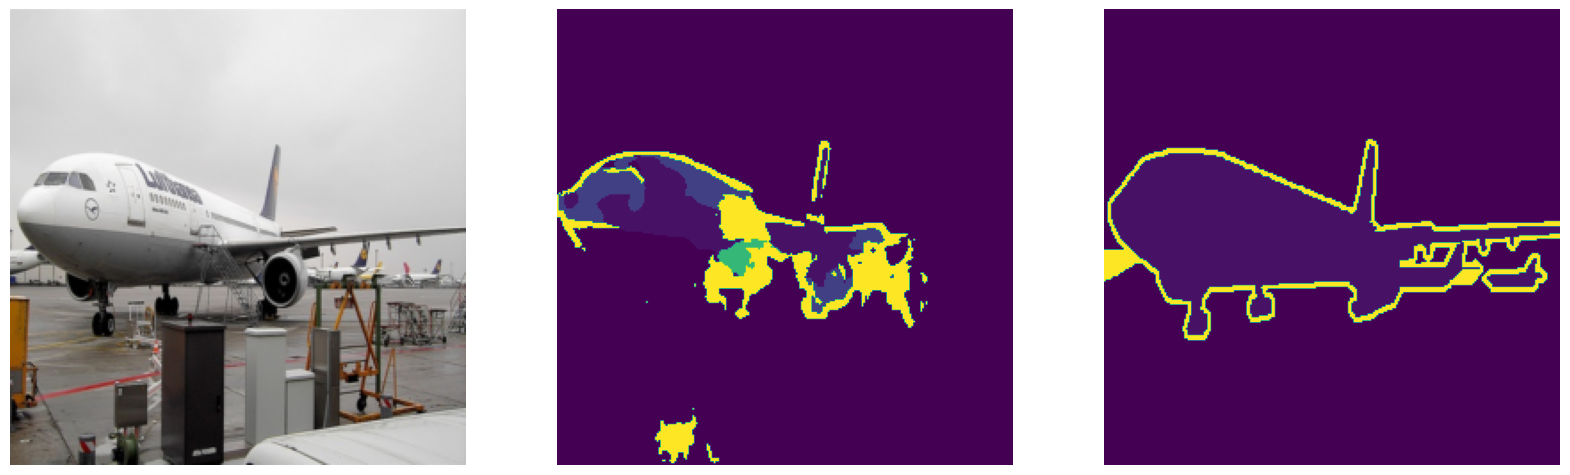

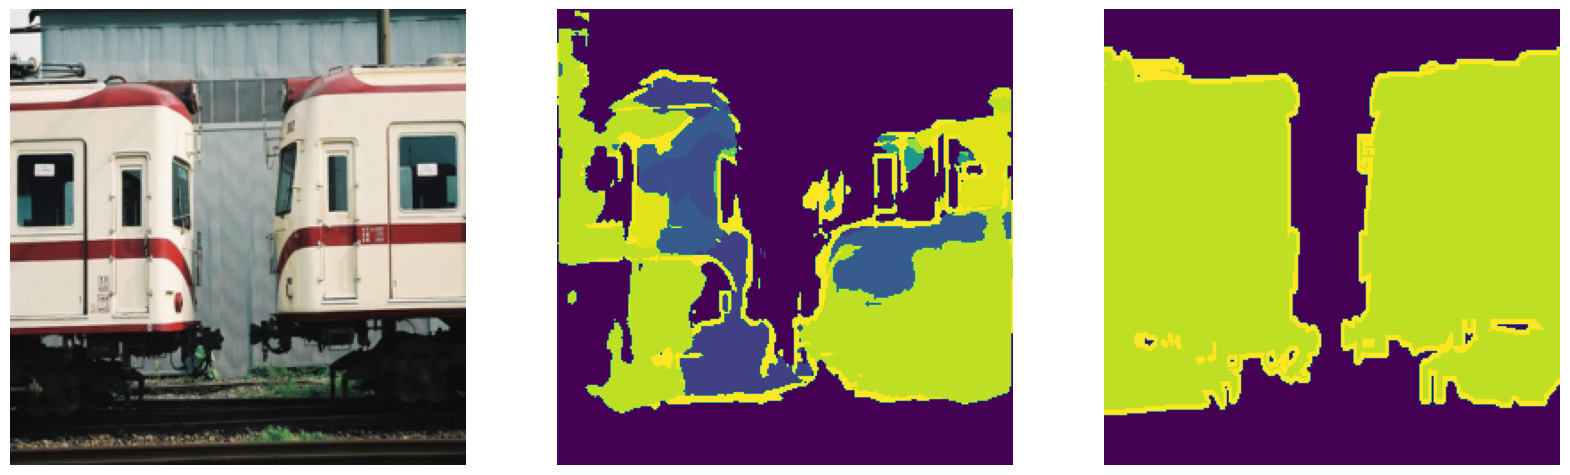

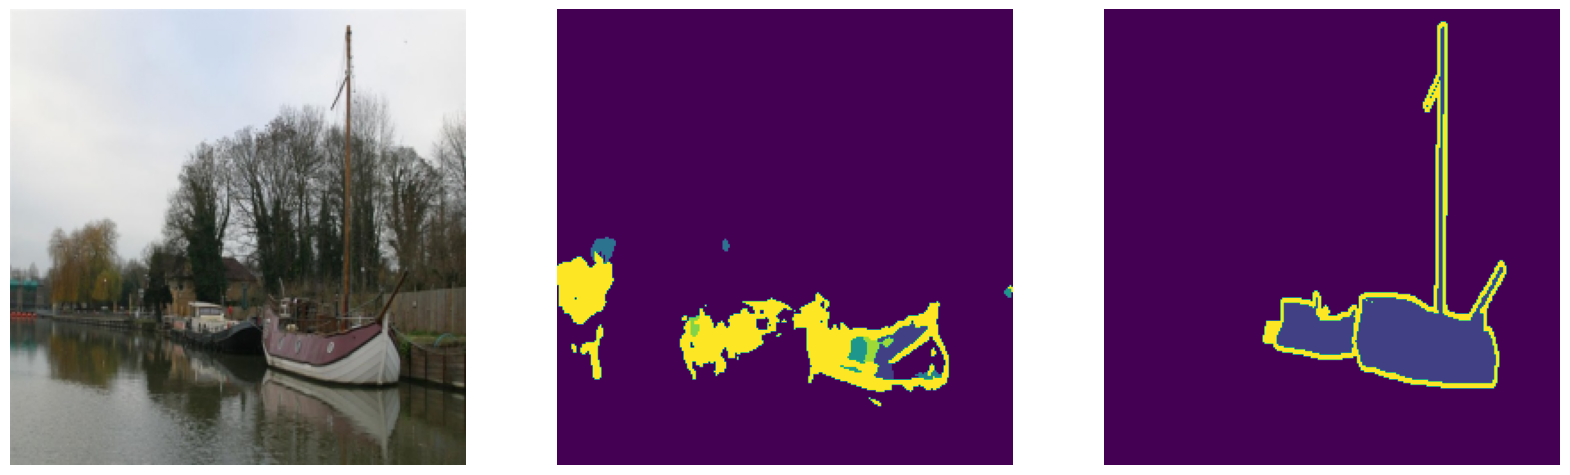

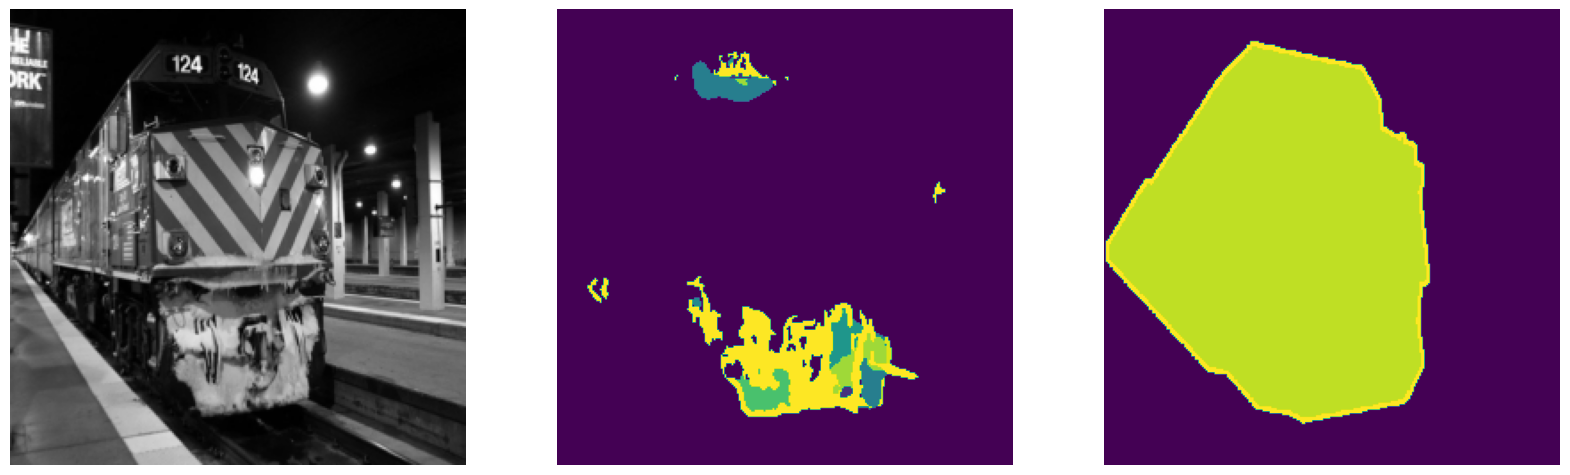

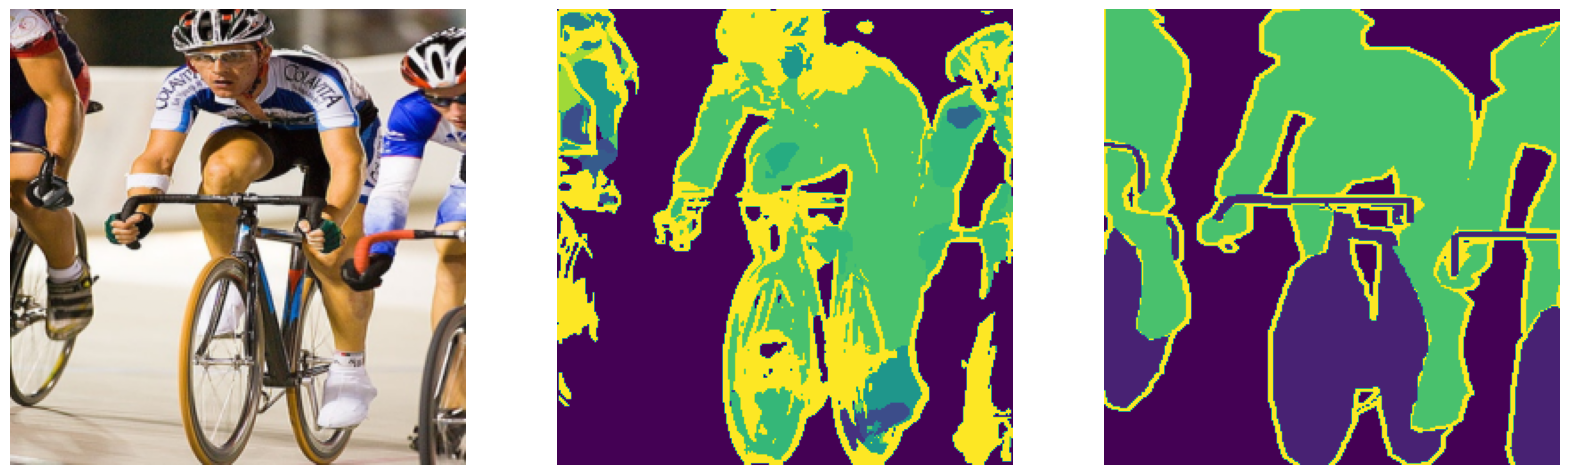

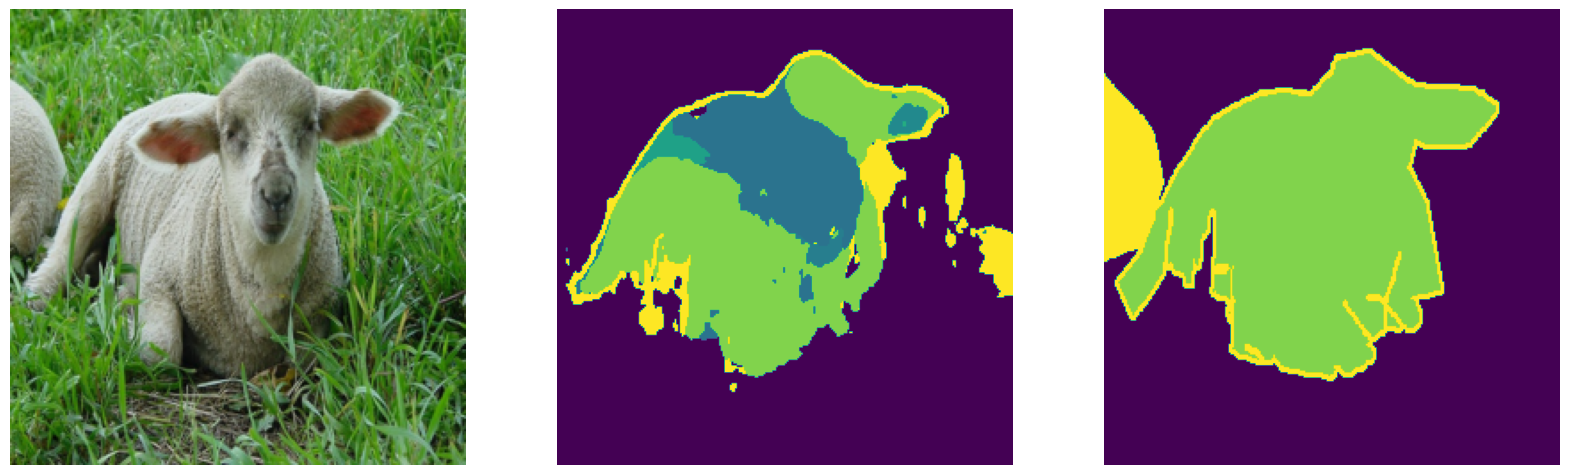

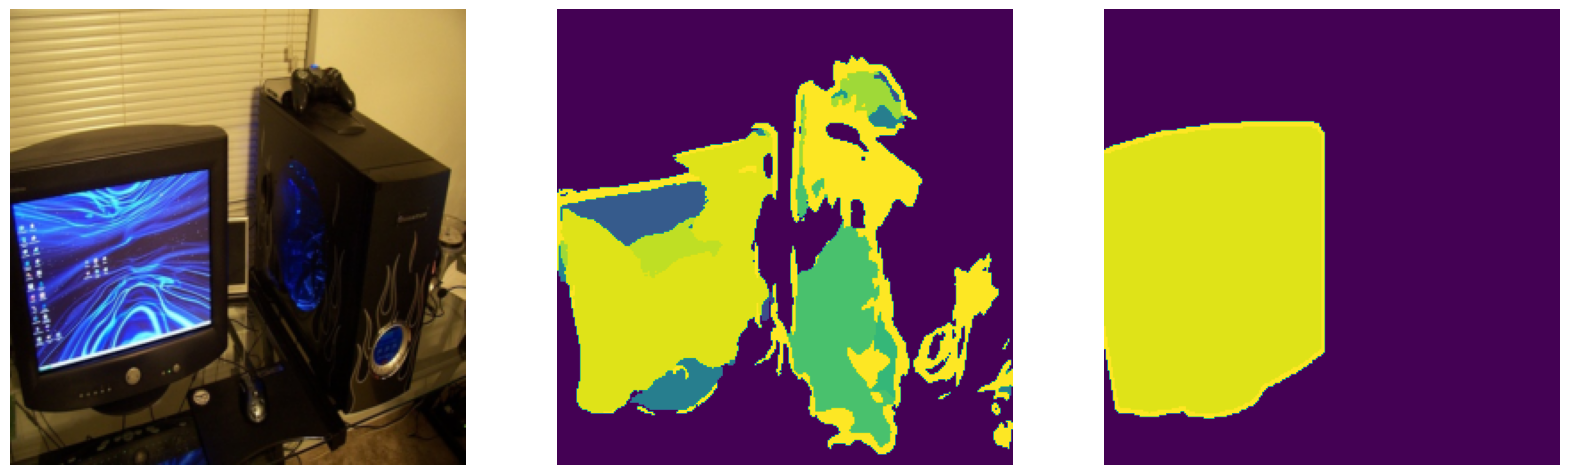

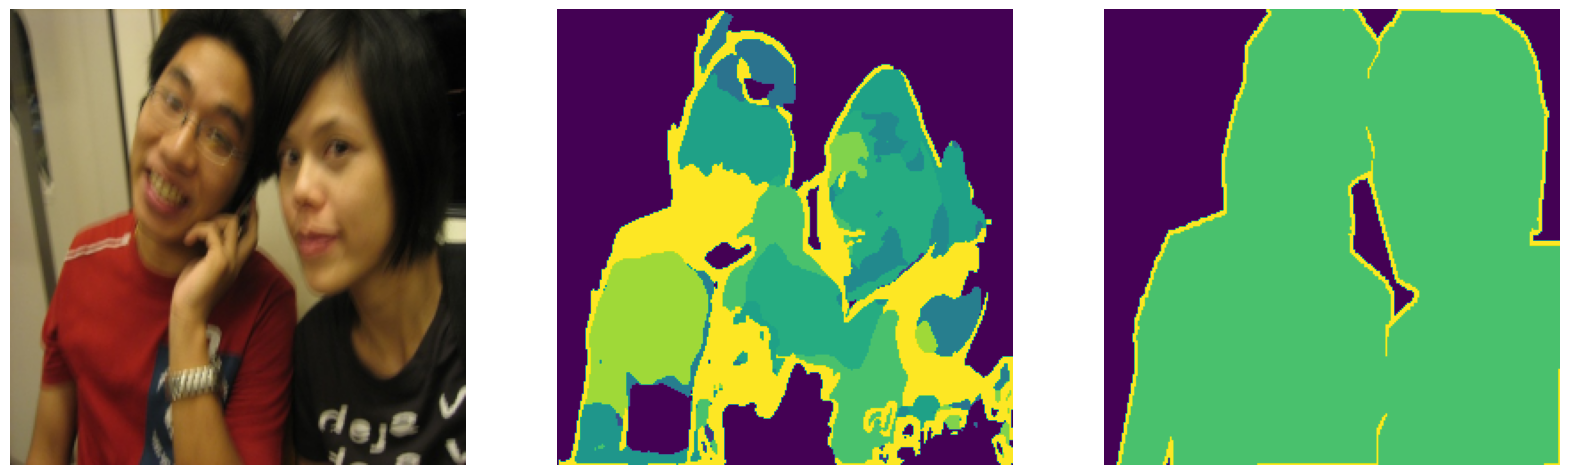

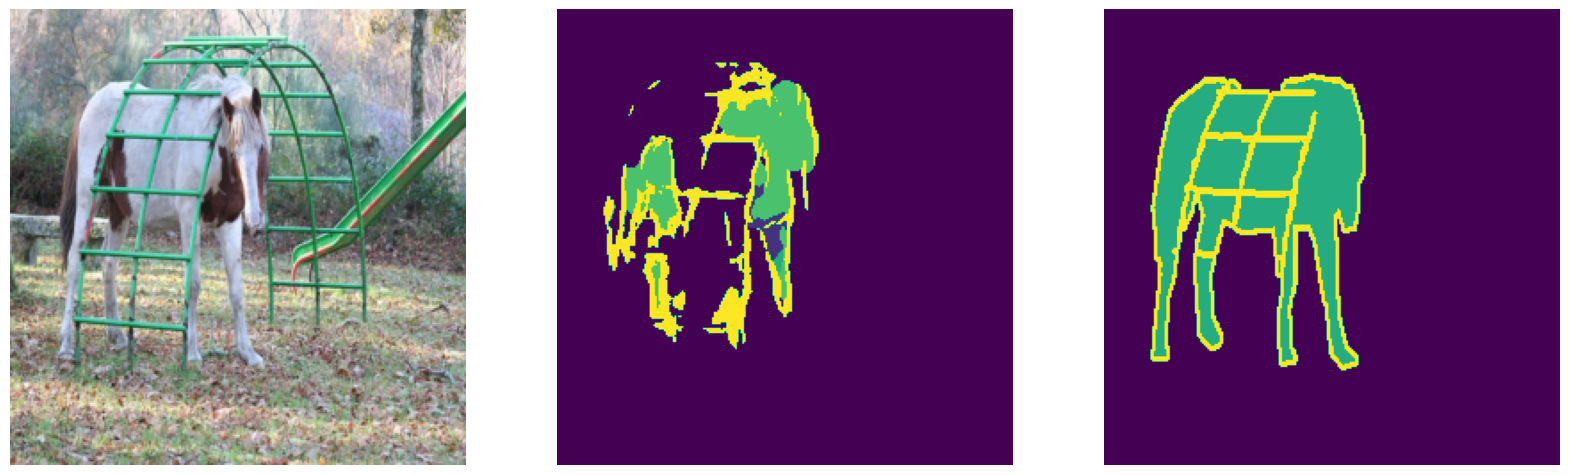

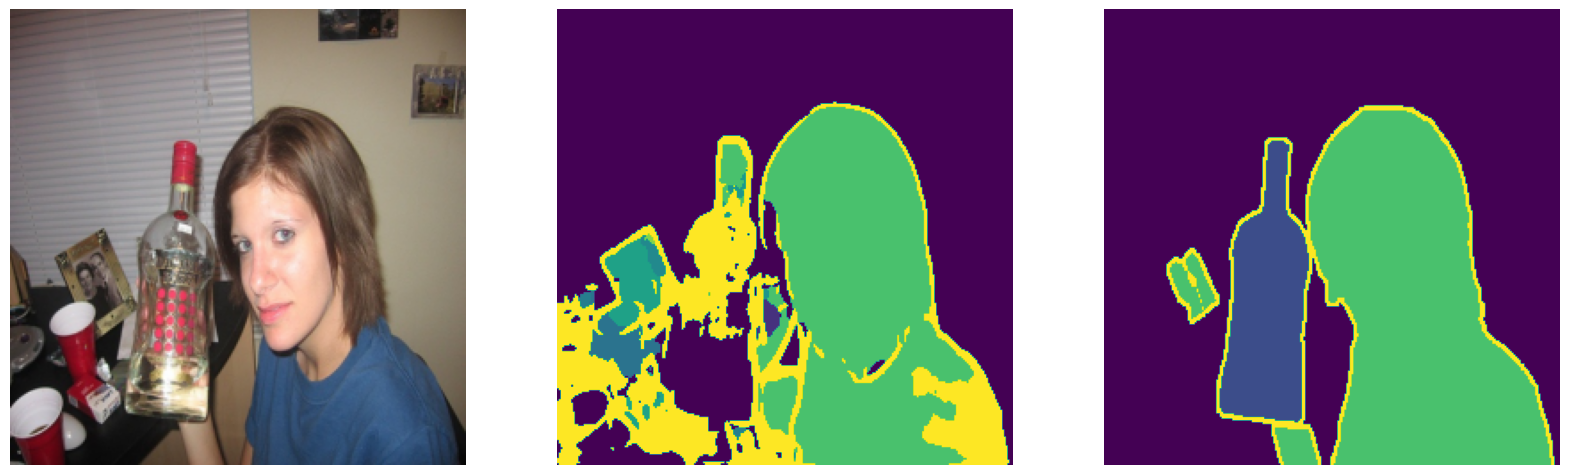

In [13]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')